HMDA(The Home Mortgage Disclosure Act)是某国一项法案，他规定金融机构必须将提供抵押贷款的数据向全社会公开。这些数据有助于显示出贷款机构是否为真正需要住房相关的客户而服务，通过分析这些数据，可以对政府官员的决策制定提供帮助，并且有可能揭示某些具有歧视性的贷款模式。
原始数据含有变量共有47个，目标变量为 action_taken_name，可以简单的理解为申请贷款的结果，我们将从数据理解入手，展现一个完整的数据挖掘流程。
在该数据集内包含2016年466,566项华盛顿州住房贷款观察数据-- --变量包括：人口统计资料、地区特定数据、贷款状况、财产类型、贷款类型、贷款目的和来源机构。
启示
看看华盛顿州的房屋贷款有什么当前的趋势吗？
贷款批准决策中有哪些重要因素？
是否存在人口或性别偏见？
可以建立ML来预测贷款决策？

实验思路
本实验主要采用pandas加载数据，进行数据的预处理，然后分析属性之间的相关性，探索数据内部的关系，接着采用分类模型算法中的决策树、随机森林与梯度提升树进行分类预测，并从中挑选出效果相对较好的预测模型，然后采用网格搜索的方式进行最优参数搜索，获取最优分类模型。


In [3]:
import pandas as pd
import seaborn as sns
import missingno #专门用做缺失值的可视化处理库
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math
from matplotlib import gridspec
#程序运行过程中忽略警告信息
import warnings
warnings.filterwarnings("ignore")

# 设置中文字体（确保系统支持中文显示）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#导入数据拆分算法train_test_split进行数据集的拆分
from sklearn.model_selection import train_test_split

# 在Jupyter上画图，# 使用该魔法，不用写plt.show()
%matplotlib inline

In [4]:
#这里读取的数据是与项目文件同级目录下，或同一个文件夹中。
hdma_raw = pd.read_csv(r"C:\Users\cheng\Desktop\2025机器学习大作业\集成学习\贷款产品预测\Washington_State_HDMA-2016.csv",low_memory=False)

In [5]:
hdma=hdma_raw ### 在原始数据上复制一份数据，往复实验不用再重新读取

In [6]:
### 原始数据的重复性探索
flag = hdma.duplicated()
flag.any() 

np.False_

In [7]:
hdma.shape #获取数据规模

(466566, 47)

In [8]:
hdma.head(2)

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,state_name,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,121.690002,NaN,8381.0,23.790001,2175.0,2660.0,227,73300.0,116.0,Washington,...,Female,NaN,NaN,NaN,NaN,"Information not provided by applicant in mail,...",Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Loan originated
1,83.370003,NaN,4915.0,23.990000,1268.0,1777.0,240,57900.0,42.0,Washington,...,Male,NaN,NaN,NaN,NaN,White,Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated


经过数据的初步探索，我们大概了解到了数据集的整体规模，46W+的记录数，47个特征列（含目标列），通过对数据集前2行的简单查看，我们了解到特征列既包含数值类型，也包含字符串类型，且字符串类型较多，后续会分别对各个特征进行探索分析，若部分字符串类型的特征列不可删去，后续考虑保留用Label编码，或者One-Hot编码的方式处理。

### 1、分析目标变量，建模问题简化

##### 目标变量简要分析：对action_taken_name做简要分析，确定并简化分析目标

In [9]:
hdma['action_taken_name'].value_counts()

action_taken_name
Loan originated                                        263712
Application denied by financial institution             64177
Application withdrawn by applicant                      60358
Loan purchased by the institution                       48356
File closed for incompleteness                          18176
Application approved but not accepted                   11735
Preapproval request denied by financial institution        35
Preapproval request approved but not accepted              17
Name: count, dtype: int64

Loan originated意味着贷款申请已经获得批准，Loan purchased是指贷款人在二级市场上购买贷款，而我们的目标旨在“探寻申请人的某些信息或者行为是否会影响到最终贷款的的发放”,因此我们将这两项相关数据集删掉，然后我们将问题简化，将问题转变为一个简单的二分类问题，新增字段loan_status，如果贷款已获批准Loan originated，赋值为0.0，其他情况（即未或批准）为1.0也可设置（0和1）。 

In [10]:
#### 多分类目标问题转化为2分类问题
### 删除action_taken_name为“Application withdrawn by applicant”和“Loan purchased by the institution”，并生成新的特征列“loan_status”
hdma=hdma[hdma['action_taken_name']!="Application withdrawn by applicant"]
hdma=hdma[hdma['action_taken_name']!='Loan purchased by the institution']
hdma['loan_status']=[0.0 if x=="Loan originated" else 1.0 for x in hdma['action_taken_name']]


这段代码首先对数据集 `hdma` 进行筛选，移除了 `action_taken_name` 列中值为 `"Application withdrawn by applicant"`（申请人撤回申请）和 `"Loan purchased by the institution"`（贷款被机构购买）的行，因为这些类别可能与当前分析目标无关。随后，代码创建了一个新的二分类特征列 `loan_status`，用于将多分类问题转化为二分类问题：如果 `action_taken_name` 的值为 `"Loan originated"`（贷款发放），则 `loan_status` 标记为 `0.0`，否则标记为 `1.0`，从而简化模型训练并聚焦于区分贷款是否成功发放。

In [11]:
### 删除原先的目标列
del hdma['action_taken_name']

In [12]:
hdma.shape 

(357852, 47)

以下这段代码用于分析和可视化目标变量 `loan_status`（贷款状态）的分布情况。首先，通过 `value_counts()` 方法统计并打印 `loan_status` 中不同类别的样本数量，直观显示二分类标签（0.0 和 1.0）的分布情况。接着，使用 `sns.countplot()` 绘制直方图，横轴（`x='loan_status'`）表示贷款状态（0.0 为“贷款发放”，1.0 为其他情况），纵轴表示对应类别的样本数量。最后，通过 `plt.title()`、`plt.xlabel()` 和 `plt.ylabel()` 、横纵轴标签，并使用 `plt.show()` 显示图形，从而帮助分析数据是否均衡并辅助后续建模策略的调整。

loan_status
0.0    263712
1.0     94140
Name: count, dtype: int64


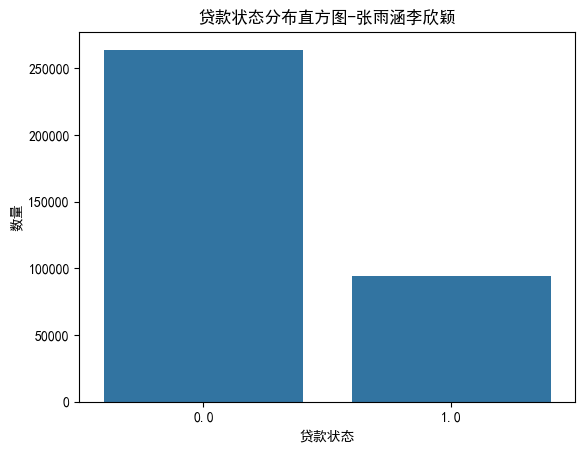

In [13]:

### 查看目标变量的分布情况，并绘制出直方图：
print(hdma['loan_status'].value_counts())
sns.countplot(x='loan_status', data=hdma)

# 添加中文标题和学生姓名
plt.title('贷款状态分布直方图-张雨涵李欣颖')  # 将"张三"替换为实际姓名
plt.xlabel('贷款状态')
plt.ylabel('数量')

plt.show()

正负样本比例大致为3:1，并非典型的样本不均衡横问题，在建模前可以不需要做特别的抽样处理（如过采样、欠采样）。

### 2、数据预处理
该步骤先对特征做初步的探索，根据字段类型的不同，将在后续步骤中采取不同的处理方式。

##### 特征的初步分析

In [14]:
hdma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357852 entries, 0 to 466565
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   tract_to_msamd_income           357494 non-null  float64
 1   rate_spread                     8638 non-null    float64
 2   population                      357497 non-null  float64
 3   minority_population             357497 non-null  float64
 4   number_of_owner_occupied_units  357492 non-null  float64
 5   number_of_1_to_4_family_units   357496 non-null  float64
 6   loan_amount_000s                357852 non-null  int64  
 7   hud_median_family_income        357499 non-null  float64
 8   applicant_income_000s           326472 non-null  float64
 9   state_name                      357852 non-null  object 
 10  state_abbr                      357852 non-null  object 
 11  sequence_number                 357852 non-null  int64  
 12  respondent_id        

In [15]:
## 基于对数据初步已知的情况，初步处理数据
#agency_name ，agency_abbr  两列实际含义相同，且取值一一致，选择删除agency_name
del hdma['agency_name'] 

In [16]:
hdma.shape

(357852, 46)

#### 处理缺失数据

一下代码使用 `missingno` 库中的 `matrix` 函数来可视化数据集 `hdma` 中缺失值（NaN）的分布情况。`figsize=(20,5)` 设置了图形的尺寸，宽度为 20 英寸，高度为 5 英寸，以便更清晰地观察数据缺失模式。生成的矩阵图中，每列代表一个字段，空白部分表示缺失值，而有颜色的部分表示有效数据。通过这种可视化方式，可以快速识别哪些字段存在较多缺失值，以及缺失值是否集中在某些特定的行或列，从而为后续的数据清洗（如填充或删除缺失值）提供依据。

<Axes: >

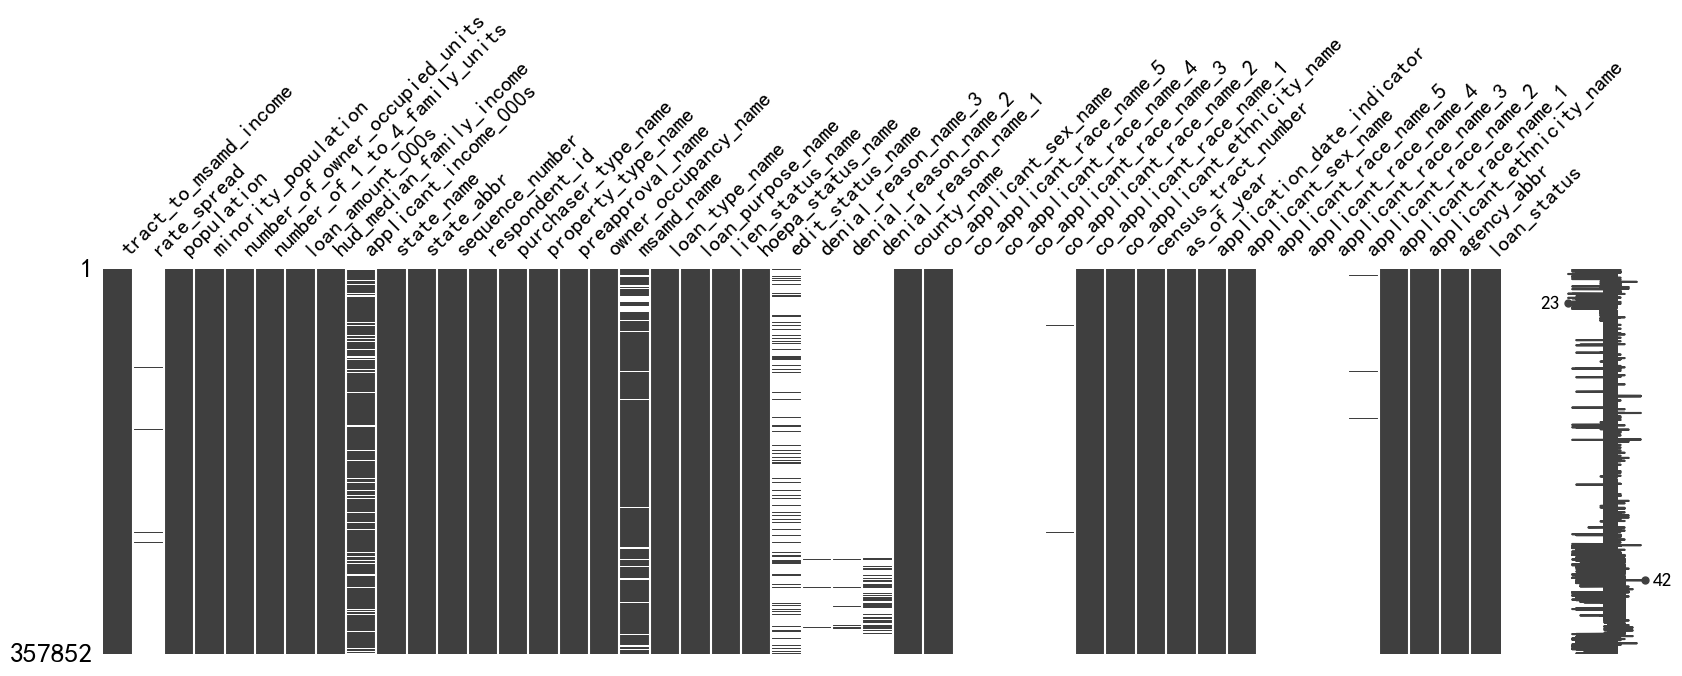

In [17]:
#继续查看数据集所有字段类型为nan的情况
missingno.matrix(hdma, figsize = (20,5))


以下代码用于统计分析数据集中各特征的缺失值比例，首先通过`hdma.isnull().sum()`计算每个特征列的缺失值数量，再除以数据集总行数`hdma.shape[0]`得到缺失率，并将结果存储在列名为'miss'的DataFrame中；然后使用`sort_values()`按缺失率从高到低排序，并通过切片`[:15]`筛选出缺失率最高的前15个特征，最终输出一个包含特征名和对应缺失率的两列表格。该分析能直观展示各特征的缺失情况，帮助识别缺失严重的特征，为后续数据清洗中决定是否删除、填充或保留这些特征提供重要依据。

In [18]:
#统计各特征的缺失率
pd.DataFrame(hdma.isnull().sum()/hdma.shape[0],columns=['miss']).sort_values(by='miss',ascending=False)[:15]

,miss
co_applicant_race_name_5,0.999969
co_applicant_race_name_4,0.999952
applicant_race_name_5,0.999899
applicant_race_name_4,0.999852
co_applicant_race_name_3,0.999748
applicant_race_name_3,0.999327
denial_reason_name_3,0.996518
co_applicant_race_name_2,0.995780
applicant_race_name_2,0.989800
denial_reason_name_2,0.981149


以下代码用于识别并删除数据集中缺失率过高的特征。首先创建一个空列表`del_col`用于存储待删除的列名，然后通过`for`循环遍历数据集的每一列，计算各列的缺失值占比（当前列的缺失值数量除以数据集总行数）。当某列的缺失率超过80%（即`>0.8`）时，将该列名添加到待删除列表`del_col`中。这种处理方式能有效剔除数据质量过差的特征，避免这些包含大量缺失值的特征影响后续分析和建模的准确性，是数据清洗过程中的预处理手段。

In [19]:
#统计各特征的缺失率,将缺失率大于80%的特征筛选出来直接删除
del_col=[]
for i,column in enumerate(hdma.columns):
    if hdma[column].isnull().sum()/hdma.shape[0] >0.8:
        del_col.append(column)

In [20]:
del_col

['rate_spread',
 'edit_status_name',
 'denial_reason_name_3',
 'denial_reason_name_2',
 'denial_reason_name_1',
 'co_applicant_race_name_5',
 'co_applicant_race_name_4',
 'co_applicant_race_name_3',
 'co_applicant_race_name_2',
 'applicant_race_name_5',
 'applicant_race_name_4',
 'applicant_race_name_3',
 'applicant_race_name_2']

In [21]:
#### 根据info信息直接删除缺失值占比超过80%的特征
hdma=hdma.drop(columns = del_col)

##### 对有少量确实的数字用0进行填充？还是选择删除这些缺失值在的行？先统计下缺失值所在的任一行有的总数

以下代码用于识别数据集中缺失率在0%到20%之间的特征列，并将这些列名存储在`del_col2`列表中。通过遍历数据集`hdma`的所有列，计算每列的缺失值比例（缺失值数量除以总行数），然后筛选出那些缺失率大于0%但小于20%的列。这种处理通常用于识别可能需要填充或特殊处理的低缺失率特征，与之前删除高缺失率特征的代码形成互补，共同完成数据质量评估工作。

In [22]:
del_col2=[]
for i,column in enumerate(hdma.columns):
    if ((hdma[column].isnull().sum()/hdma.shape[0] <0.2) &(hdma[column].isnull().sum()/hdma.shape[0] >0)):
        del_col2.append(column)

In [23]:
hdma_miss=hdma[del_col2]

以下代码定义了一个名为`plot_distribution`的可视化函数，用于自动绘制数据集中各特征的分布情况。函数首先设置经典样式和中文字体支持，然后根据特征数量动态计算子图布局（行数和列数），并添加包含学生姓名的总标题。对于数值型特征，使用核密度估计图展示分布；对于类别型特征，则绘制水平条形图显示类别频次。通过调整`hspace`和`wspace`参数控制子图间距，并采用`tight_layout`优化整体布局，确保标题不被遮挡。最后通过示例调用展示了如何用3列布局、20x20英寸画布尺寸来可视化`hdma_miss`数据集，其中`hspace=0.45`和`wspace=0.5`分别控制着子图间垂直和水平间距。

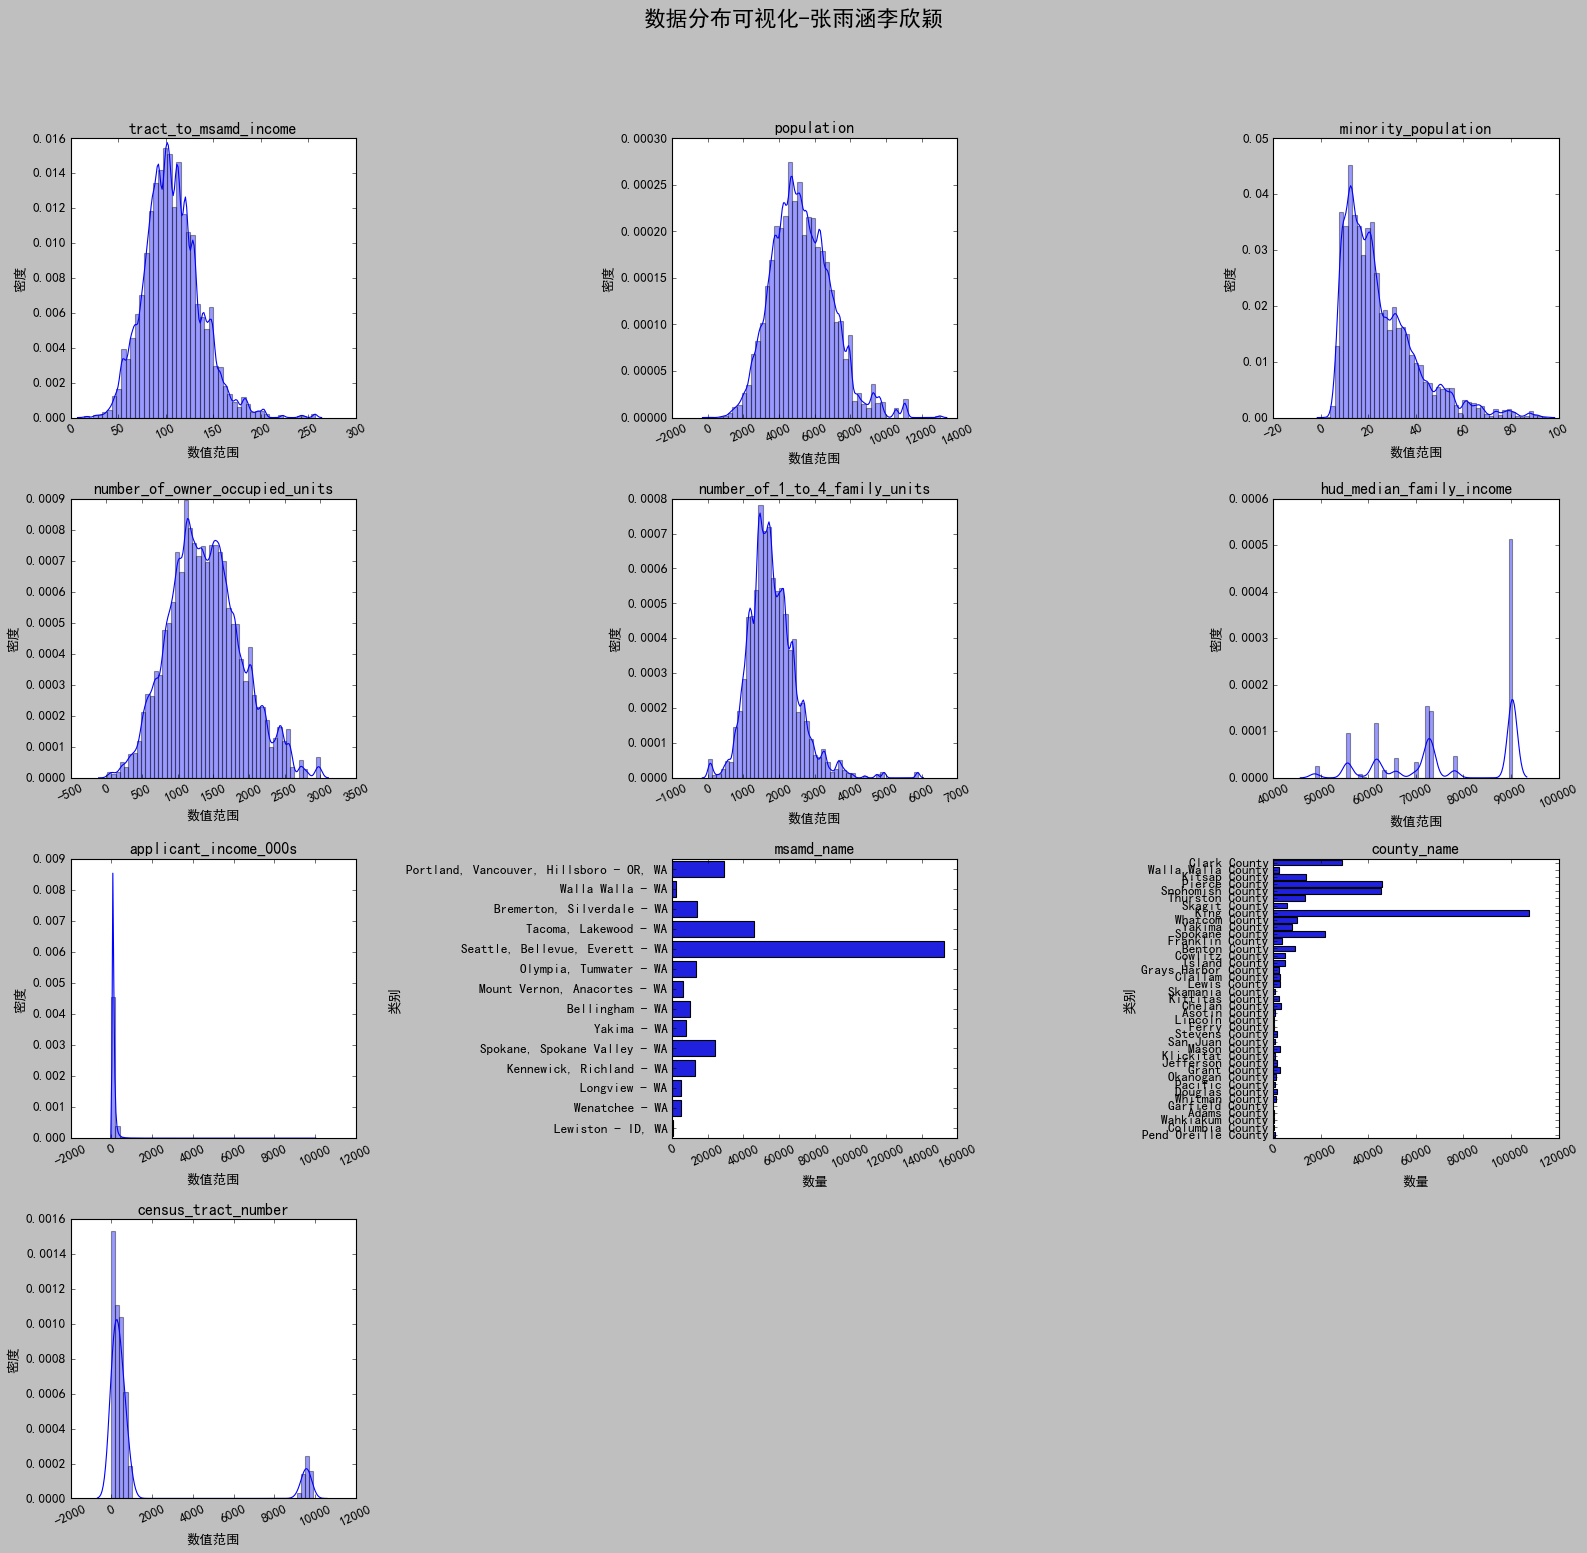

In [24]:

def plot_distribution(df, cols=5, width=15, height=20, hspace=0.2, wspace=0.5, student_name="张雨涵李欣颖"):
    plt.style.use('classic') 
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=0.1, right=0.9, hspace=hspace, wspace=wspace)
    rows = math.ceil(float(df.shape[1]) / cols)
    
    # 添加主标题
    fig.suptitle(f'数据分布可视化-{student_name}', fontsize=20, y=0.97)  # 上移标题
    
    for i, column in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        
        if df.dtypes[column] == object:
            g = sns.countplot(y=column, data=df)
            ax.set_xlabel('数量')
            ax.set_ylabel('类别') 
        else:
            g = sns.distplot(df[column])
            ax.set_xlabel('数值范围') 
            ax.set_ylabel('密度')
            
        plt.xticks(rotation=25)
    
    # 优化布局（核心修改点）
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # 顶部保留7%空间给主标题
    plt.show()

# 调用示例
plot_distribution(hdma_miss, 
                 cols=3, 
                 width=20, 
                 height=20, 
                 hspace=0.45, 
                 wspace=0.5, 
                 student_name="张雨涵李欣颖")

In [25]:
hdma=hdma.dropna()     #默认滤除任意有缺失值在的行

In [26]:
hdma.shape

(300175, 33)

#### 根据特征类型，按照数值型与标称型分布分别分析
特征列的类型有int64、float64、object，我们将这些类型分为两个大类进行更严格的探索和分析，第一类，数值类型，包括int64和float64，第二类字符串类型object。并且根据no-null值，可以初步判断有特征列（如applicant_race_name_5、applicant_race_name_4）存在缺失值过多，直接删除特征。

以下代码使用`describe()`方法对数据集`hdma`中的数值型属性进行统计性描述分析，该方法会自动计算并返回各数值列的关键统计指标，包括数据计数（count）、平均值（mean）、标准差（std）、最小值（min）、下四分位数（25%）、中位数（50%）、上四分位数（75%）以及最大值（max）。通过这个简洁的统计分析，我们可以快速掌握数据集中数值特征的集中趋势、离散程度和分布范围，识别潜在的异常值或数据分布异常情况，为后续的数据清洗和特征工程提供重要参考依据。

In [27]:
## 查看数值型属性统计性描述
hdma.describe()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,census_tract_number,as_of_year,application_date_indicator,loan_status
count,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,3.001750e+05,300175.000000,300175.0,300175.0,300175.000000
mean,107.565574,5318.159723,25.528260,1385.743153,1770.756715,290.625895,78976.084284,114.543616,9.616981e+04,929.199688,2016.0,0.0,0.255791
std,30.113663,1624.899427,15.218358,498.786135,610.076896,392.651777,11889.894229,125.846933,1.711085e+05,2261.752846,0.0,0.0,0.436306
min,14.050000,98.000000,2.040000,14.000000,27.000000,1.000000,48700.000000,1.000000,1.000000e+00,1.000000,2016.0,0.0,0.000000
25%,87.209999,4181.000000,14.110000,1033.000000,1385.000000,176.000000,72300.000000,61.000000,4.404000e+03,117.000000,2016.0,0.0,0.000000
50%,105.029999,5192.000000,21.320000,1361.000000,1719.000000,254.000000,78100.000000,90.000000,2.292000e+04,321.020000,2016.0,0.0,0.000000
75%,125.430000,6364.000000,33.220001,1701.000000,2142.000000,360.000000,90300.000000,135.000000,9.121250e+04,528.060000,2016.0,0.0,1.000000
max,257.140015,11041.000000,94.790001,2997.000000,4746.000000,99999.000000,90300.000000,9999.000000,1.241016e+06,9705.000000,2016.0,0.0,1.000000


In [28]:
# 标量型特征属性统计性描述
hdma.describe(include=['O'])

,state_name,state_abbr,respondent_id,purchaser_type_name,property_type_name,preapproval_name,owner_occupancy_name,msamd_name,loan_type_name,loan_purpose_name,lien_status_name,hoepa_status_name,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr
count,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175,300175
unique,1,1,704,10,2,3,3,14,4,3,3,2,21,5,8,5,4,7,4,6
top,Washington,WA,451965,Loan was not originated or was not sold in cal...,One-to-four family dwelling (other than manufa...,Not applicable,Owner-occupied as a principal dwelling,"Seattle, Bellevue, Everett - WA",Conventional,Refinancing,Secured by a first lien,Not a HOEPA loan,King County,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD
freq,300175,300175,18708,124245,292780,246852,276457,143098,236843,153318,288432,300166,101475,142943,142943,142943,194477,215898,242849,155187


top描述的是出现频率最高的字段，而freq则是描述该字段出现的次数。

1）单值特征不具备区分样本的能力，对任何分类任务都毫无贡献；
2）保留这类特征会增加计算复杂度却不会提升模型性能；
3）可能干扰特征重要性分析，这种处理方式既优化了数据结构，又避免了无意义特征对模型产生的噪声干扰；

##### 某些分布只有1个值，对分类结果的影响应该可以视为没有，选择删除（思考下为什么）

以下代码用于识别并删除数据集中取值单一的特征列，首先创建一个空列表`del_col2`来存储待删除的列名，然后遍历数据集的每一列，通过`hdma[column].unique()`检查每列的唯一值数量，当某列只有一个唯一值（即所有样本在该特征上取值完全相同）时，将该列名加入待删除列表。最后打印出这些无信息量的特征列名，并从数据集中删除这些列，同时输出处理后的数据集维度信息。这种处理能有效剔除对模型训练无贡献的冗余特征，减少数据维度，提高后续建模的效率和性能。

In [29]:
### 根据统计描述，处理分布极端的特征：筛选出来取值只有1个值的特征
del_col2=[]
for i, column in enumerate(hdma.columns):
    if len(hdma[column].unique())==1:
        del_col2.append(column)
print(del_col2)
hdma=hdma.drop(columns = del_col2)
hdma.shape

['state_name', 'state_abbr', 'as_of_year', 'application_date_indicator']


(300175, 29)

In [30]:
hdma.shape

(300175, 29)

##### 对其他数值类型的变量做相关性分析。
特征相关性分析，去除相关性较高的特征之一

以下代码使用Seaborn库绘制了一个10×8英寸的Pearson相关系数热力图，用于可视化数据集中数值型变量之间的线性相关性。代码首先计算数值变量间的相关系数矩阵，然后通过热力图形式展示，其中每个单元格的颜色深浅和标注的数值（annot=True）直观反映了变量间的相关程度。最后调用tight_layout()自动调整子图参数避免标签重叠，完整展示了各数据字段间的相关关系。

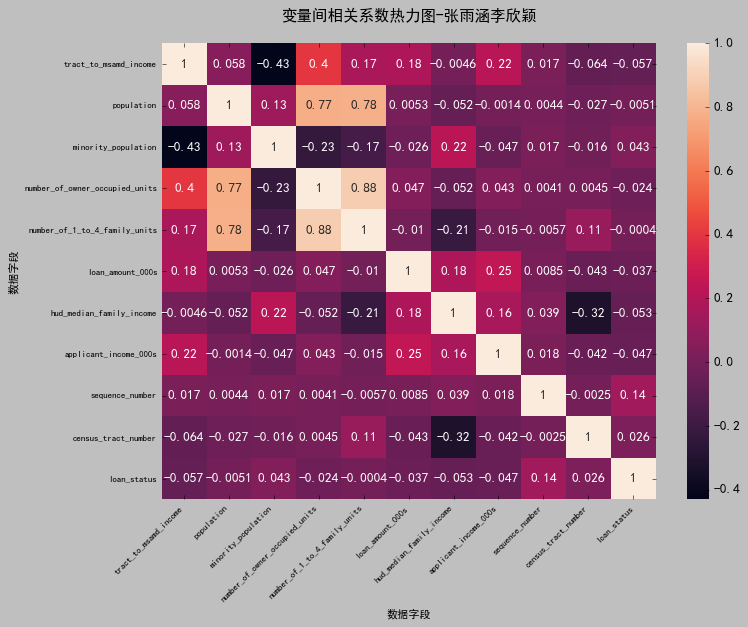

In [31]:

plt.figure(figsize=(10, 8))
sns.heatmap(hdma.corr(method='pearson', numeric_only=True), annot=True)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 添加标题和坐标轴标签
current_ax = plt.gca()                           # 获取当前坐标轴
current_ax.set_title("变量间相关系数热力图-张雨涵李欣颖", fontsize=14, pad=20)
current_ax.set_xlabel("数据字段", fontsize=10)     # X轴标签
current_ax.set_ylabel("数据字段", fontsize=10)     # Y轴标签

# 优化刻度显示
plt.xticks(rotation=45, ha='right', fontsize=8)   # X轴标签旋转45度
plt.yticks(rotation=0, fontsize=8)               # Y轴保持水平

# 强制重绘图形以应用字体设置
plt.draw()

# 调整布局防止标签被截断
plt.tight_layout()
plt.show()

可以看出，'population'、'number_of_owner_occupied_units'、'number_of_1_to_4_family_units'这3个特征相关度（大于70%）很高，可以考虑只保留一个。这里保留population字段。

以下代码从`hdma`数据集中删除了两个特定的特征列：`number_of_owner_occupied_units`（业主自住单元数量）和`number_of_1_to_4_family_units`（1-4户家庭单元数量）。这种特征删除操作通常基于以下分析结论：1）这两个特征可能与其他特征存在高度相关性（如之前热力图分析显示的多重共线性问题）；
2）特征本身可能包含大量缺失值或单一取值；
3）业务角度判断这些特征对预测目标贡献有限。
通过删除冗余或无关特征，可以简化模型结构、提高计算效率，并避免过拟合风险，是特征工程中常用的降维手段。删除操作后，数据集维度将减少两列，但保留了更核心的特征信息。

In [32]:
del hdma['number_of_owner_occupied_units']
del hdma['number_of_1_to_4_family_units']

以下代码用于识别数据集中需要分箱处理的数值型特征，具体实现过程是：首先创建一个空列表`bins_col`存储待分箱特征，然后遍历数据集的每一列，通过`hdma[column].dtype != object`判断是否为数值型特征，对于数值型特征进一步检查其标准差是否大于100（`hdma[column].std() > 100`），将满足条件的特征名加入列表。这种处理主要针对那些数值范围较大、波动剧烈的连续变量（如金额、计数等），通过后续的分箱操作（如等宽分箱、等频分箱）可以将连续值转换为离散区间，既能降低异常值影响，又能更好地捕捉非线性关系，提高模型的鲁棒性和可解释性。

In [33]:
bins_col = []
for column in hdma.columns:
    # 检查列是否为非对象类型（数值型）
    if hdma[column].dtype != object:
        # 检查标准差是否大于100
        if hdma[column].std() > 100:
            bins_col.append(column)
print(bins_col)

['population', 'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s', 'sequence_number', 'census_tract_number']


以下代码创建了一个专业化的多子图可视化布局，用于对比分析关键数值特征在不同贷款状态下的分布差异。代码首先生成一个12×28英寸的大画布，采用10行3列的网格布局（GridSpec）来组织子图。对每个需要分箱的数值特征（bins_col列表中的特征），分别绘制两条核密度曲线：蓝色曲线表示贷款通过状态（loan_status=1）的分布，红色曲线表示贷款拒绝状态（loan_status=0）的分布。每个子图都包含特征名称标题、坐标轴标签和图例说明，并通过调整字体大小（fontsize）和旋转角度（rotation=30）优化标签显示效果。最后使用tight_layout()自动调整子图间距，并预留3%的底部空间和2%的顶部空间（rect参数）来确保标题和标签完整显示。

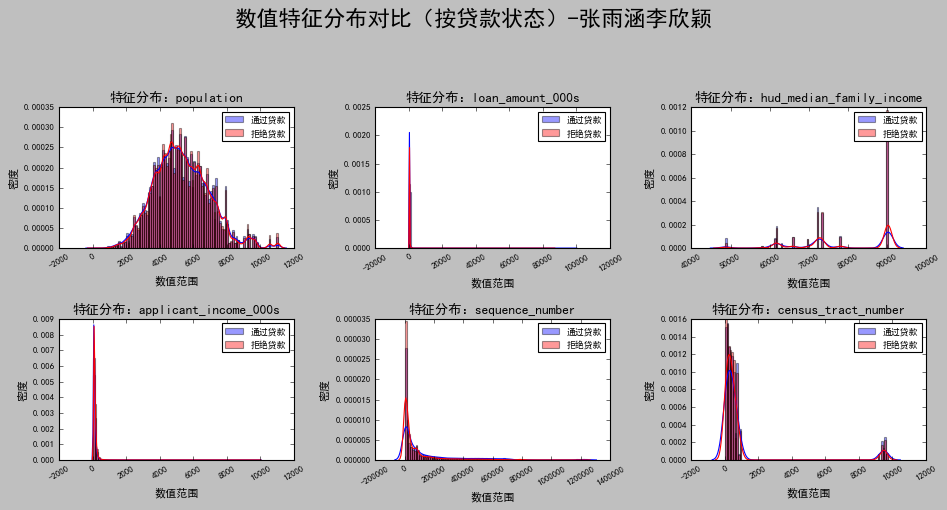

In [34]:
# 创建画布
plt.figure(figsize=(12, 28))
fig = plt.gcf()
fig.suptitle('数值特征分布对比（按贷款状态）-张雨涵李欣颖', fontsize=20, y=0.995)  # 主标题

# 创建网格布局
gr = gridspec.GridSpec(10, 3)  # 10行3列布局

# 遍历分箱特征
for i, feature in enumerate(bins_col):
    ax = plt.subplot(gr[i])
    
    # 绘制分布图
    sns.distplot(hdma[feature][hdma.loan_status == 1], 
                 bins=100, color='b', label='通过贷款')
    sns.distplot(hdma[feature][hdma.loan_status == 0], 
                 bins=100, color='r', label='拒绝贷款')
    
    # 设置子图元素
    ax.set_title(f'特征分布：{feature}', fontsize=12)          # 子图标题
    ax.set_xlabel('数值范围', fontsize=10)                    # X轴标签
    ax.set_ylabel('密度', fontsize=10)                       # Y轴标签
    ax.legend(loc='upper right', fontsize=8)                 # 添加图例
    
    # 优化刻度显示
    plt.xticks(fontsize=8, rotation=30)
    plt.yticks(fontsize=8)

# 调整整体布局
plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # 为主标题留出空间
plt.show()

In [35]:
hdma.shape

(300175, 27)

In [36]:
#####  对数值特征中，标准差大于100的特征进行分箱
hdma[column]= pd.cut(hdma[column], 100)

In [37]:
# hdma.info()

LabelEncoder
即将离散型的数据转换成0到 n−1 之间的数，n 是一个列表的不同取值的个数，可以认为是某个特征的所有不同取值的个数。

以下代码使用Scikit-learn的LabelEncoder对数据集中的分类特征进行数值编码转换。首先将整个hdma数据集强制转换为字符串类型(astype(str))以确保统一处理，然后通过apply方法结合LabelEncoder的fit_transform函数，将所有的分类变量（包括字符串型和类别型）转换为连续的数值标签。这种编码方式虽然简单高效，将每个类别映射为一个唯一的整数，但需要注意其可能引入的数值大小关系（如将"高/中/低"编码为2/1/0）可能被某些算法误认为存在数量级差异，因此更适合树模型等对数值尺度不敏感的算法使用。编码后的结果存储在hdma_enc变量中，为后续的机器学习建模做好了数据准备。

In [38]:
### 特征编码
# 转换为连续型数字变量
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# print(dataset_con['workclass'])
hdma = hdma.astype(str)
hdma_enc = hdma.apply(encoder.fit_transform) 

In [39]:
#### 统一编码之后可以知道那两列完成重复？

In [40]:
hdma_enc.describe()

,tract_to_msamd_income,population,minority_population,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,respondent_id,purchaser_type_name,property_type_name,...,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,census_tract_number,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,loan_status
count,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,...,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000,300175.000000
mean,563.213852,676.612516,509.082628,879.730351,10.283625,675.690471,67087.250664,368.969904,5.004008,0.975364,...,10.106578,1.674733,5.359210,2.284964,507.891913,1.388077,4.922712,1.757728,2.032794,0.255791
std,355.129194,312.362060,310.848409,335.436209,3.394708,422.868039,40350.707579,193.234815,2.279002,0.155012,...,4.557132,1.385786,1.620519,0.720627,316.920292,0.870356,1.810047,0.536200,1.466589,0.436306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,258.000000,432.000000,241.000000,709.000000,9.000000,276.000000,31998.000000,225.000000,2.000000,1.000000,...,8.000000,0.000000,5.000000,2.000000,220.000000,0.000000,3.000000,2.000000,0.000000,0.000000
50%,500.000000,711.000000,488.000000,906.000000,12.000000,705.000000,65435.000000,371.000000,6.000000,1.000000,...,9.000000,2.000000,5.000000,2.000000,495.000000,2.000000,6.000000,2.000000,3.000000,0.000000
75%,897.000000,946.000000,751.000000,1073.000000,13.000000,1057.000000,103116.500000,557.000000,7.000000,1.000000,...,14.000000,3.000000,7.000000,3.000000,779.000000,2.000000,6.000000,2.000000,3.000000,1.000000
max,1183.000000,1154.000000,1096.000000,1771.000000,13.000000,1370.000000,136748.000000,703.000000,9.000000,1.000000,...,20.000000,4.000000,7.000000,4.000000,1075.000000,3.000000,6.000000,3.000000,5.000000,1.000000


In [41]:
hdma_enc.shape

(300175, 27)

### 建立模型

In [42]:
#将数据拆分为训练数据和测试数据
x_cols = [col for col in hdma_enc.columns if col!='loan_status' ]
y_col = 'loan_status'
X=hdma_enc[x_cols]
y=hdma_enc[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [43]:
X

,tract_to_msamd_income,population,minority_population,loan_amount_000s,hud_median_family_income,applicant_income_000s,sequence_number,respondent_id,purchaser_type_name,property_type_name,...,hoepa_status_name,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,census_tract_number,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr
0,304,1128,462,801,10,104,8082,377,4,1,...,1,3,2,3,3,554,0,3,2,0
1,936,644,471,835,1,756,92513,579,6,1,...,1,18,3,5,2,984,2,6,0,3
2,1058,689,63,838,10,110,104710,578,7,1,...,1,3,0,7,3,561,2,6,2,3
3,478,678,1033,1027,10,604,34647,379,7,1,...,1,3,0,3,1,486,2,3,1,4
4,539,715,17,1108,12,94,62081,278,4,1,...,1,9,2,7,3,957,0,6,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452834,689,291,282,962,9,1239,120298,225,7,1,...,1,11,3,5,2,908,2,6,2,3
452837,449,1115,213,1228,13,461,119047,225,7,1,...,1,8,1,3,1,202,1,3,1,3
464253,22,1136,746,987,4,1124,119734,225,7,1,...,1,12,0,7,3,1046,2,6,2,3
466564,1021,596,823,874,9,1155,120984,225,7,1,...,1,11,0,7,3,829,2,6,2,3


In [44]:
import time,datetime

In [45]:
#导入决策树模型
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
#采用决策树模型进行训练
dt_model.fit(X_train, y_train)
y_pred=dt_model.predict(X_test)
#打印模型评估值
print (dt_model.score(X_test, y_test))

0.8821249708504991


In [46]:
#导入随机森林模型
from sklearn.ensemble import RandomForestClassifier
#配置模型中树的个数为100
rf_model = RandomForestClassifier (n_estimators=100)
#采用随机森林进行模型训练
rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)
#打印模型评分结果 
print (rf_model.score(X_test, y_test))  #0.9059298036439509

0.9024019188699988


<Axes: >

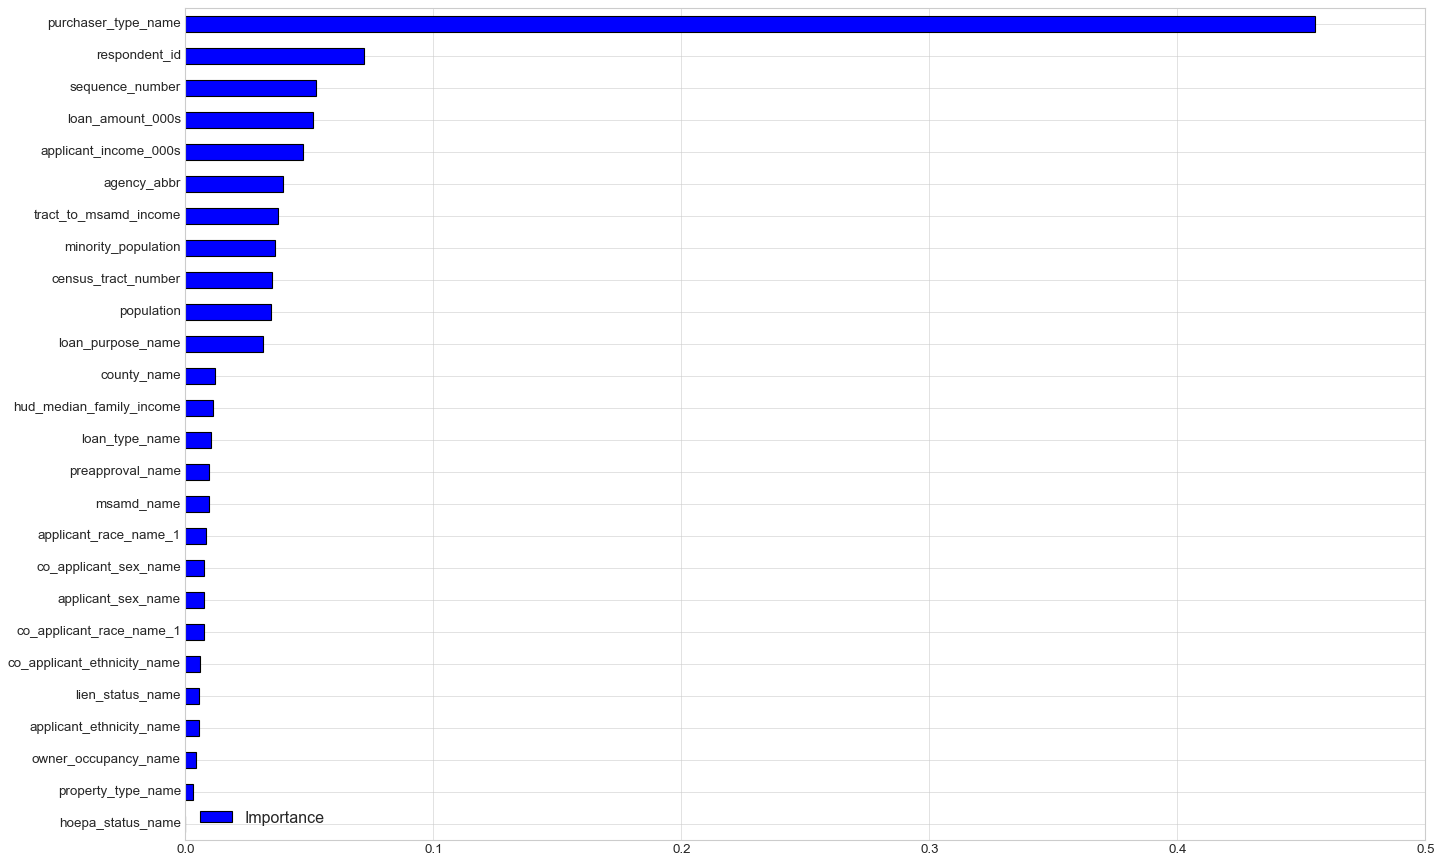

In [47]:
# 使用随机森林算法去查看属性重要性
plt.style.use('seaborn-v0_8-whitegrid')
importance = rf_model.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=["Importance"])
#根据数值大小排序
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2))


In [48]:
###  查看重要性突出的特征的分布（在原始数据中取值，训练用的已经编码处理了）
hdma['purchaser_type_name'].value_counts()

purchaser_type_name
Loan was not originated or was not sold in calendar year covered by register    124245
Fannie Mae (FNMA)                                                                61291
Freddie Mac (FHLMC)                                                              39450
Ginnie Mae (GNMA)                                                                26251
Life insurance company, credit union, mortgage bank, or finance company          17798
Commercial bank, savings bank or savings association                             15883
Other type of purchaser                                                          10506
Affiliate institution                                                             3186
Private securitization                                                            1552
Farmer Mac (FAMC)                                                                   13
Name: count, dtype: int64

补充逻辑回归模型和KNN模型进行评估

In [49]:
#导入逻辑回归模型（补充）
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 数据预处理（假设已完成特征编码和分箱，X_train, X_test, y_train, y_test 已拆分）
# 初始化逻辑回归模型（L2正则化，C=1.0）
lr_model = LogisticRegression(penalty='l2', C=1.0, random_state=10, max_iter=1000)
lr_model.fit(X_train, y_train)

# 预测测试集
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # 正类概率

# 评估指标
print("逻辑回归模型评估：")
print(f"准确率：{accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1值：{f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC：{roc_auc_score(y_test, y_prob_lr):.4f}")

逻辑回归模型评估：
准确率：0.7778
F1值：0.5379
AUC-ROC：0.8572


In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# 假设使用部分数据进行训练和测试
X_train_sample = X_train[:1000]  # 使用前1000个样本
y_train_sample = y_train[:1000]
X_test_sample = X_test[:100]     # 使用前100个样本
y_test_sample = y_test[:100]

# 配置KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=3,           # 减小K值
    weights='uniform',       # 权重计算方式
    n_jobs=-1                # 并行计算
)

# 模型训练
knn_model.fit(X_train_sample, y_train_sample)

# 预测
y_pred = knn_model.predict(X_test_sample)
y_pred_proba = knn_model.predict_proba(X_test_sample)[:, 1]  # 获取正类概率

# 模型评估
accuracy = accuracy_score(y_test_sample, y_pred)
precision = precision_score(y_test_sample, y_pred)
recall = recall_score(y_test_sample, y_pred)
f1 = f1_score(y_test_sample, y_pred)
auc = roc_auc_score(y_test_sample, y_pred_proba)

# 输出评估结果
print("K近邻模型评估结果：")
print(f"准确率: {accuracy:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"AUC值: {auc:.4f}")

# 注意：KNN没有特征重要性，因为它是基于距离的模型
print("\nKNN模型没有特征重要性指标")


K近邻模型评估结果：
准确率: 0.7100
精确率: 0.5000
召回率: 0.3103
F1分数: 0.3830
AUC值: 0.6025

KNN模型没有特征重要性指标


In [ ]:
#导入GBDT模型
from sklearn.ensemble import GradientBoostingClassifier
#配置GBDT分类器个数
gbdt_model = GradientBoostingClassifier(n_estimators=100)
#采用训练数据集进行模型训练
gbdt_model.fit(X_train, y_train)
y_pred=gbdt_model.predict(X_test)
#输出模型评估值
print (gbdt_model.score(X_test, y_test))

0.8925299545823016


**算法解读：**作为GBDT的高效实现，**XGBoost是一个上限特别高的算法**，在算法竞赛中比较受欢迎。对比原算法GBDT，XGBoost主要从下面三个方面做了优化：

　　　　一是算法本身的优化：在算法的弱学习器模型选择上，对比GBDT只支持决策树，还可以直接很多其他的弱学习器。在算法的损失函数上，除了本身的损失，还加上了正则化部分。在算法的优化方式上，GBDT的损失函数只对误差部分做负梯度（一阶泰勒）展开，而XGBoost损失函数对误差部分做二阶泰勒展开，更加准确。

　　　　二是算法运行效率的优化：对每个弱学习器，比如决策树建立的过程做并行选择，找到合适的子树分裂特征和特征值。在并行选择之前，先对所有的特征的值进行排序分组，方便前面说的并行选择。对分组的特征，选择合适的分组大小，使用CPU缓存进行读取加速。将各个分组保存到多个硬盘以提高IO速度。

　　　　三是算法健壮性的优化：对于缺失值的特征，通过枚举所有缺失值在当前节点是进入左子树还是右子树来决定缺失值的处理方式。算法本身加入了L1和L2正则化项，可以防止过拟合，泛化能力更强。

In [ ]:
#导入XGBoost分类模型

import xgboost as xgb  #主要是c语言实现的，本实验是通过python接口调用
xgb_model_1 = xgb.XGBClassifier(
max_depth=6                    #构建树的深度，越大越容易过拟合,需要使用 CV 函数来进行调优。 典型值：3-10 
,learning_rate=0.3             #学习率
,n_estimators=100              #树的个数    
,scale_pos_weight=1            #两种类别的权重设置，如果设置为大于1，会加快收敛，
,objective='binary:logistic'   #设置目标函数，此处为二分类对应的目标函数，输出对应分类结果的概率 	
,eval_metric='auc'             #分类任务(默认error)  ,auc--roc曲线下面积
,subsample=1                   #控制对于每棵树，随机采样的比例。 典型值：0.5-1
,seed=123                      #随机数种子,用于产生可复现的结果 
)


#采用训练数据集进行模型训练
xgb_model_1.fit(X_train, y_train)
y_pred=xgb_model_1.predict(X_test)
#输出模型评估值
print (xgb_model_1.score(X_test, y_test))

0.9092534396411003


可以看到XGBoost在四个算法中预测结果比较突出，且运行效率也较高，接下来考虑选择XGBoost算法作为最终模型算法，从模型泛化能力和预测精度两个方面对模型进行提升。

##### 选择XGBoost算法进行交叉验证

交叉验证评估原始模型的优势：
1：交叉验证用于评估模型的预测性能，尤其是训练好的模型在新数据上的表现，可以在一定程度上减小过拟合。
2：还可以从有限的数据中获取尽可能多的有效信息。

In [ ]:
###选择XGBoost算法进行交叉验证
#首先通过交叉验证的方式检查样本分布不均是否对模型造成影响
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,roc_auc_score,make_scorer,f1_score
from sklearn.model_selection import cross_val_score,GridSearchCV

cv_scores = cross_val_score(xgb_model_1, X_train, y_train,scoring=make_scorer(f1_score) ,cv=3)
print('mean f1_score socre of raw model {}'.format(np.mean(cv_scores)))

mean f1_score socre of raw model 0.8178826658989086


选出XGBoost算法进行最后预测模型，对其参数进行网格搜索

### **网格搜索**

   对最初性能表现突出的模型进行调参，选出XGBoost算法进行最后预测模型，对其参数进行网格搜索。网格搜索（GridSearch）用于选取模型的最优超参数。获取最优超参数的方式可以绘制验证曲线，但是验证曲线只能每次获取一个最优超参数。如果多个超参数有很多排列组合的话，就可以使用网格搜索寻求最优超参数的组合

**GridSearchCV()**
    **estimator:**选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数。
    **param_grid:**需要最优化的参数的取值，值为字典或者列表，键命名必须为模型本身的参数名称
    **scoring：**模型评价标准，默认None(即选择的estimator的误差估计函数)。常为'f1','accuracy','recall','roc_auc',‘average_precision’
    **cv=None,**交叉验证参数，默认3

**网格搜索过渡方法-坐标下降**：拿当前对模型影响最大的参数调优，直到最优化；再拿下一个影响最大的参数调优，如此下去，直到所有的参数调整完毕。这个方法的缺点就是可能会调到局部最优而不是全局最优，但是省时间省力。如下即使用坐标下降的思路进行超参数调优。
————————————————
https://blog.csdn.net/mr_trustin/java/article/details/96614446

#####  网格搜索参数调整，调节scale_pos_weight

尝试找的较匹配的参数，进而提升模型性能 根据前面的参数设置，我们仅从3个比较主要的参数入手进行网格搜索，这三个参数基本描述为：



n_estimators         #树的个数

max_depth            #构建树的深度，越大越容易过拟合

learning_rate        #学习率 

网格搜索过渡方法-坐标下降：拿当前对模型影响最大的参数调优，直到最优化；再拿下一个影响最大的参数调优，如此下去，直到所有的参数调整完毕。这个方法的缺点就是可能会调到局部最优而不是全局最优，但是省时间省力。如下即使用坐标下降的思路进行超参数调优。

In [ ]:
# 训练开始计时
import time, datetime
start_time = time.time()

#### 利用坐标下降的方式，对XGBoost模型的关键参数进行搜索，尝试获取更好的建模结果
#首先对参数 n_estimators 进行搜索
param_test1 = {'n_estimators':range(90,151,20)}
gsearch1 = GridSearchCV(estimator = xgb_model_1, 
                        param_grid = param_test1,
                        scoring=make_scorer(f1_score)
                       )
gsearch1.fit(X_train,y_train)
print('best params:{}'.format(gsearch1.best_params_))
print('best score:{}'.format(gsearch1.best_score_))

# 训练结束计时
print("Running Time: %s" % datetime.timedelta(seconds=(time.time() - start_time)))

best params:{'n_estimators': 150}
best score:0.8199478969022111
Running Time: 0:00:13.402383


In [ ]:
#首先对参数 max_depth 进行搜索
param_test2 = {'max_depth':range(3,10,2)}
gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_,
                        param_grid = param_test2,
                        scoring=make_scorer(f1_score))
gsearch2.fit(X_train,y_train)
print('best params2:{}'.format(gsearch2.best_params_))
print('best score:{}'.format(gsearch2.best_score_))

best params2:{'max_depth': 7}
best score:0.8197154192481312


In [ ]:
#首先对参数 learning_rate 进行搜索
param_test3 = {'learning_rate':[0.05,0.1,0.3,0.5,0.7]}
gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_,
                        param_grid = param_test3,
                        scoring=make_scorer(f1_score))
gsearch3.fit(X_train,y_train)
print('best params3:{}'.format(gsearch3.best_params_))
print('best score:{}'.format(gsearch3.best_score_))

best params3:{'learning_rate': 0.3}
best score:0.8197154192481312


GridSearchCV 在完成超参数搜索后，会通过 best_estimator_ 属性返回最佳参数组合对应的模型，输出的 XGBClassifier 参数列表内容：展示了最佳模型的超参数配置，部分参数已从默认值调整为调优后的结果。（n_estimators=150，max_depth=7，learning_rate=0.3）

In [ ]:
gsearch3.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

将序列化后的（best_estimator_）经过GridSearchCV得到的最佳XGBoost模型保存到到文件xgb_model.pkl(为二进制序列化文件)中，便于之后直接加载使用，无需重新训练。

In [ ]:
#模型保存
import joblib
joblib.dump(gsearch3.best_estimator_,'xgb_model.pkl')

['xgb_model.pkl']

In [ ]:
#利用最终确认的模型训练
model_load = joblib.load('xgb_model.pkl')
y_test_pred = model_load.predict(X_test)
print('f1 score of random forest score:{}'.format(f1_score(y_test,y_test_pred)))


f1 score of random forest score:0.8227357354068557


 **XGBoost模型小结：**该模型本身的参数优化 效果一般不是特别大，更为重要的是数据清洗和特征工程。 